In [1]:
import pandas as pd
import numpy as np

wine = pd.read_csv("winemag dataset.csv")
wine.drop_duplicates(subset=None, keep='first', inplace=True)
wine.dropna(axis=0, how='any', subset=['variety'], inplace=True) 
wine['description'] = wine['description'].str.lower()
wine['variety'] = wine['variety'].str.lower()

In [2]:
print(wine.shape)
wine.head(3)

(137325, 9)


,points,title,description,taster_name,price,variety,province,country,winery
0,89,Argiolas 2017 Perdera (Monica di Sardegna),"fragrant blue flower, mediterranean herb and w...",Kerin O’Keefe,19.0,red blends,Sicily & Sardinia,Italy,Argiolas
1,89,Argiolas 2018 Costamolino (Vermentino di Sard...,spring blossom and yellow stone fruit aromas m...,Kerin O’Keefe,19.0,vermentino,Sicily & Sardinia,Italy,Argiolas
2,89,"Bushong 2017 Power, Corruption & Lies Red (Pas...","deep, dark and intense aromas of blackberry me...",Matt Kettmann,43.0,rhône-style red blend,California,US,Bushong


In [3]:
data = wine.groupby('variety').filter(lambda x: len(x) > 2000).reset_index(drop=True)
data['variety'].unique()   

array(['riesling', 'cabernet sauvignon', 'bordeaux-style red blend',
       'merlot', 'chardonnay', 'white blend', 'sparkling blend',
       'sauvignon blanc', 'sangiovese', 'malbec', 'portuguese red',
       'pinot noir', 'rosé', 'nebbiolo', 'zinfandel', 'syrah',
       'red blend'], dtype=object)

In [4]:
data = data[~data['variety'].isin(['bordeaux-style red blend', 'white blend', 'portuguese red', 'red blend'])] 
data['variety'].unique()    

array(['riesling', 'cabernet sauvignon', 'merlot', 'chardonnay',
       'sparkling blend', 'sauvignon blanc', 'sangiovese', 'malbec',
       'pinot noir', 'rosé', 'nebbiolo', 'zinfandel', 'syrah'],
      dtype=object)

In [5]:
print('There are totally', len(wine.variety.value_counts()), 'kinds of wine.')
print('Here we just select', len(data.variety.value_counts()), 'kinds.')

There are totally 780 kinds of wine.
Here we just select 13 kinds.


In [6]:
data.variety.value_counts()

pinot noir            14467
chardonnay            12337
cabernet sauvignon     9885
riesling               5484
sauvignon blanc        5265
syrah                  4321
rosé                   4004
nebbiolo               3251
merlot                 3119
zinfandel              2797
sangiovese             2767
malbec                 2656
sparkling blend        2270
Name: variety, dtype: int64

<AxesSubplot:title={'center':'Number of descriptions per Variety'}, xlabel='variety', ylabel='count'>

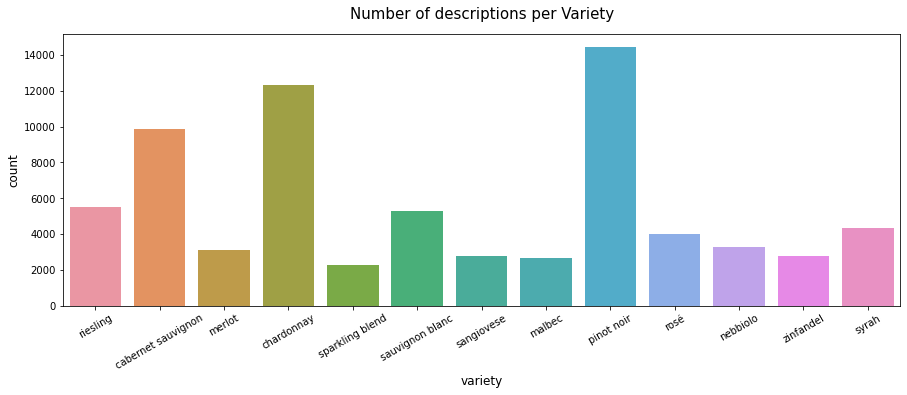

In [7]:
import matplotlib.pyplot as plt  
import seaborn as sns

plt.figure(figsize=(15,5))     
plt.title('Number of descriptions per Variety', size=15, pad=15)   
plt.xlabel('variety', fontsize=12) 
plt.xticks(rotation=30) 
plt.ylabel('count', fontsize=12) 
sns.set_color_codes("pastel")
sns.countplot(x="variety", data=data)

In [53]:
colour_map = {'pinot noir': 'red', 'chardonnay': 'white', 'cabernet sauvignon': 'red', 'riesling': 'white', 
              'sauvignon blanc': 'white', 'syrah': 'red', 'rosé': 'red', 'nebbiolo': 'red', 'merlot': 'red', 
              'zinfandel': 'white', 'sangiovese': 'red', 'malbec': 'red', 'sparkling blend': 'white'}

In [59]:
data_color = data.copy()
data_color['colour'] = data_color.apply(lambda row: colour_map[row['variety']], axis=1)
colour_dummies = pd.get_dummies(data_color['colour'])
data_color = data_color.merge(colour_dummies, left_index=True, right_index=True)
data_color.reset_index(drop=True)
data_color.head()

,points,title,description,taster_name,price,variety,province,country,winery,colour,red,white
0,89,Buttonwood Grove 2017 Riesling (Finger Lakes),honey-drizzled pear and peach meld with a bit ...,Alexander Peartree,16.0,riesling,New York,US,Buttonwood Grove,white,0,1
1,89,Casa Silva 2018 Los Lingues Vineyard Estate Gr...,leathery plum and berry aromas show some oak i...,Michael Schachner,20.0,cabernet sauvignon,Colchagua Valley,Chile,Casa Silva,red,1,0
3,89,Château Jean Gué 2016 Lalande de Pomerol,this softly textured wine shows plenty of ripe...,Roger Voss,22.0,merlot,Bordeaux,France,Château Jean Gué,red,1,0
5,89,Château le Thil 2017 Pessac-Léognan,"pure merlot, this wine is rich, full, dense an...",Roger Voss,NaN,merlot,Bordeaux,France,Château le Thil,red,1,0
9,89,Cielo Malibu Estate Vineyards 2017 Malibu Esta...,fresh black-currant aromas meet with root beer...,Matt Kettmann,100.0,cabernet sauvignon,California,US,Cielo Malibu Estate Vineyards,red,1,0


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[a-z]+')        
stops = set(stop_words.ENGLISH_STOP_WORDS)   
wines = set([w for v in wine['variety'].unique() for w in tokenizer.tokenize(v.lower())])  
sets = set(['wine','wines','red','white','flavors','flavor','drink','zin'])

stopwords = stops | wines | sets      # update the stopwords

In [62]:
from xgboost import XGBClassifier

vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', stop_words=stopwords, norm='l2')
clf = XGBClassifier(random_state=123, seed=2, colsample_bytree=0.6, subsample=0.7)   # XGBoost classifier

In [65]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Pipeline with helper functions
# Transformer to select a single column from the data frame to perform additional transformations on

class TextSelector(BaseEstimator, TransformerMixin):    # use on text columns in the data
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None, *parg, **kwarg):
        return self
    def transform(self, X):
        return X[self.key]               # returns the input as a string
    
class NumberSelector(BaseEstimator, TransformerMixin):  # use on numeric columns in the data
    def __init__(self, key):     
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]]             # returns the input as a dataframe

In [66]:
text = Pipeline([('selector', TextSelector(key='description')), ('vectorizer', vec_tdidf)])
red = Pipeline([('selector', NumberSelector(key='red'))])
white = Pipeline([('selector', NumberSelector(key='white'))])

features = FeatureUnion([('description', text), ('red', red), ('white', white)])
pipe = Pipeline([('feats', features), ('clf',clf)])

In [67]:
# hyperparameter tuning
pipe.named_steps['clf'].get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 2}

In [70]:
from sklearn.model_selection import train_test_split, GridSearchCV

df_X = data_color[['description', 'white', 'red']]
df_y = data_color['variety']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=123, stratify=df_y)
X_train

,description,white,red
40538,"from the pratt vineyard on sexton road, this i...",0,1
50048,reasonably accurate on the nose for leyda sauv...,1,0
7859,"red fruits give this ripe, rounded wine weight...",0,1
69236,polarity is an unusual golden-hued wine made f...,0,1
29637,this wine brings aromas and flavors of pear al...,1,0
...,...,...,...
14067,"saturated in color as well as on the nose, thi...",0,1
9323,"black currant, vanilla and coffee ground notes...",0,1
39239,"aromas of vanilla, coconut and wood spice lead...",1,0
92388,earthy cherry and berry aromas include a black...,0,1


In [71]:
# definition of parameter grid to scan through
param_grid = {    
     'clf__n_estimators': [50,100,300]
     'clf__colsample_bytree': [0.6,0.8,1]
     'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 3, n_jobs = 1, verbose = 0, 
                           return_train_score=True)

In [72]:
grid_search.fit(X_train, y_train)   # hyperparameter fitting

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feats',
                                        FeatureUnion(transformer_list=[('description',
                                                                        Pipeline(steps=[('selector',
                                                                                         TextSelector(key='description')),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer(stop_words={'a',
                                                                                                                     'abouriou',
                                                                                                                     'about',
                                                                                                                     'above',
               

In [74]:
grid_search.cv_results_['mean_train_score']

array([0.80588244, 0.87270272, 0.97587531])

In [75]:
grid_search.cv_results_['mean_test_score']

array([0.71320245, 0.72629294, 0.73042392])

In [76]:
grid_search.best_params_

{'clf__n_estimators': 300}

In [92]:
from sklearn import metrics

def print_stats(preds, target, labels, sep='-', sep_len=80, fig_size=(10,8)):
    print('XGBoost Accuracy : %.2f%%' % (metrics.accuracy_score(target, preds) * 100.0))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix:')
    cm = metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cmap = 'RdPu')
    plt.pause(0.05)

XGBoost Accuracy : 74.17%
--------------------------------------------------------------------------------
Classification report:
                    precision    recall  f1-score   support

cabernet sauvignon       0.73      0.63      0.68      2887
        chardonnay       0.89      0.80      0.85      3415
            malbec       0.44      0.57      0.50       511
            merlot       0.13      0.32      0.18       306
          nebbiolo       0.76      0.81      0.79       759
        pinot noir       0.87      0.73      0.80      4317
          riesling       0.81      0.85      0.83      1309
              rosé       0.83      0.83      0.83      1010
        sangiovese       0.53      0.70      0.61       530
   sauvignon blanc       0.69      0.78      0.73      1174
   sparkling blend       0.66      0.81      0.73       459
             syrah       0.44      0.60      0.51       798
         zinfandel       0.93      0.95      0.94       681

          accuracy          

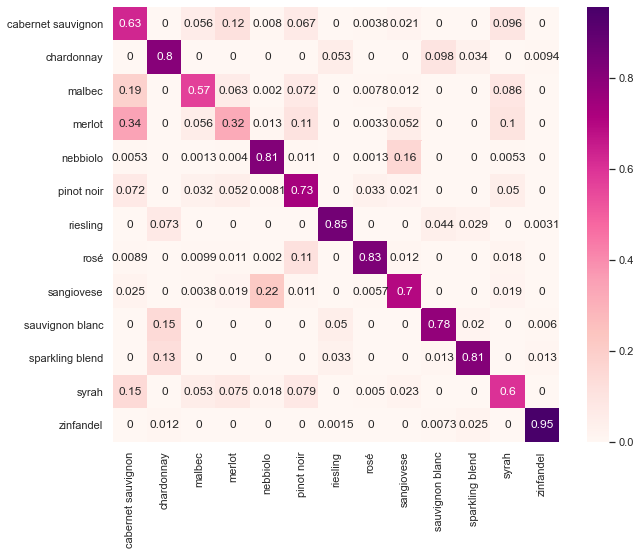

In [93]:
clf_test = grid_search.best_estimator_
preds = clf_test.predict(X_test)

print_stats(y_test, preds, clf_test.classes_)